# **1. Kết nối với Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG


# **2. Import thư viện**

In [ ]:
pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Keras and TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


# **3. Đọc dữ liệu và gán nhãn**

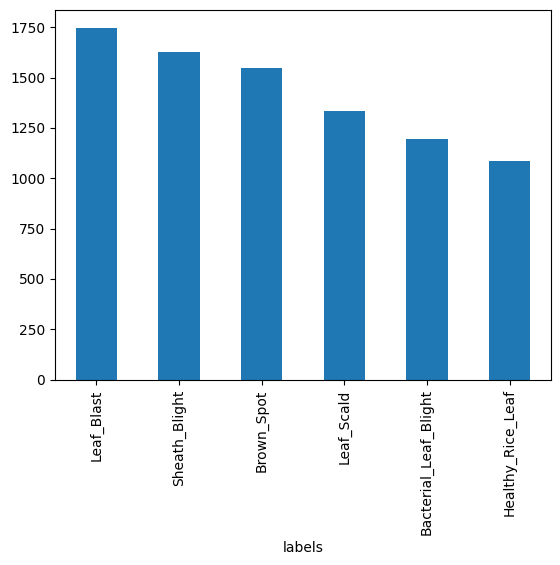

labels
Leaf_Blast               1748
Sheath_Blight            1629
Brown_Spot               1546
Leaf_Scald               1332
Bacterial_Leaf_Blight    1197
Healthy_Rice_Leaf        1085
Name: count, dtype: int64


In [ ]:
# class list
classes = ["Sheath_Blight", "Leaf_Blast", "Leaf_Scald",
           "Brown_Spot", "Bacterial_Leaf_Blight", "Healthy_Rice_Leaf"]

labels = []
image_links = []
class_path ='/content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG'
# load and label emages
for class_name in classes:
    images = glob.glob(f'{class_path}/{class_name}/*.jpg')
    labels.extend([class_name] * len(images))
    image_links.extend(images)
# transfer data to dataframe
data = pd.DataFrame({'labels': labels, 'image_links': image_links})

# check the number of images per layer
data['labels'].value_counts().plot.bar()
plt.show()
print(data['labels'].value_counts())


# **4. Chia tập dữ liệu**

In [ ]:
# split the test set (15%)
images_train_val, images_test, y_train_val, y_test = train_test_split(
    image_links, labels, stratify=labels, test_size=0.15, random_state=42)

print(f'Train + Val: {len(images_train_val)}, Test: {len(images_test)}')

 # split train and validation from the train_val set
images_train, images_val, y_train, y_val = train_test_split(
    images_train_val, y_train_val, stratify=y_train_val, test_size=0.176, random_state=42) # 0.176 * 85% = 15%

print(f'Train: {len(images_train)}, Val: {len(images_val)}, Test: {len(images_test)}')


Train + Val: 7256, Test: 1281
Train: 5978, Val: 1278, Test: 1281


# **5. Tiền xử lý dữ liệu**

In [ ]:
# load and resize emages function
def load_and_resize_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Đọc ảnh
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)  # Resize ảnh về kích thước 224x224
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Đổi từ BGR sang RGB
    img_normalized = img_rgb / 255.0 # Chia giá trị pixel cho 255.0 để đưa về khoảng [0, 1].
    return img_normalized
# check emages size
for img_path in image_links:
    img = load_and_resize_image(img_path)
    if img is not None:
        # Print the processed image size
        print(f"Processed image shape for {img_path}: {img.shape}")
        if img.shape != (224, 224, 3):
            print(f"Unexpected shape for {img_path}: {img.shape}")


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3114.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3230.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3323.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3145.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3199.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3154.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Scald/aug_0_3128.jpg: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/tieuLuan/dataset/Rice_Leaf_AUG/Leaf_Sca

In [ ]:
# Sử dụng Label Encoder để chuyển nhãn từ chuỗi sang số, sau đó chuyển thành dạng one-hot cho tập train, validation và test.
# create label encoder
encoder = LabelEncoder()

# transfer label to
# numeric for train and validation dataset
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# one-hot for train and validation dataset
y_train_onehot = to_categorical(y_train_encoded, num_classes=6)
y_val_onehot = to_categorical(y_val_encoded, num_classes=6)

# numeric for test set
y_test_encoded = encoder.transform(y_test)
# initialize ImageDataGenerator for
# train set with data augmentation ((xoay, dịch chuyển, zoom, lật ngang,...) để tăng độ đa dạng dữ liệu.)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest' # fill_mode để lấp vùng ảnh bị mất sau khi biến đổi
)

#  không sử dụng augmentation — giữ nguyên dữ liệu gốc để đảm bảo đánh giá trung thực.

# validation set (no augmentation)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# test set (no augmentation)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# naming for train set, test set, validation set
train_df = pd.DataFrame({'image_links': images_train, 'labels': y_train_encoded})
val_df = pd.DataFrame({'image_links': images_val, 'labels': y_val_encoded})
test_df = pd.DataFrame({'image_links': images_test, 'labels': y_test_encoded})
# load data from DataFrame
# train set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw')

# validation set
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw')

# test set
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False)

Found 5978 validated image filenames.
Found 1278 validated image filenames.
Found 1281 validated image filenames.


In [ ]:
# check images size in train set
for i in range(6):
    img = load_and_resize_image(images_train[i])
    if img is not None:
        print(f"Image {i} shape: {img.shape}")
batch_images, batch_labels = next(train_generator)
print(f'Batch image shape: {batch_images.shape}')
print(f'Batch label shape: {batch_labels.shape}')

Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Image 5 shape: (224, 224, 3)
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


# **6. Trích xuất đặc trưng bằng ResNet50**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Thêm tầng GlobalAveragePooling2D để rút trích đặc trưng đầu ra 2048 chiều.
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# hàm trích xuất tính năng
def extract_features(generator, num_samples):
    features = np.zeros((num_samples, 2048))
    labels = []

    current_idx = 0

    for i, (batch_imgs, batch_labels) in enumerate(generator):
        print(f"Batch {i} - batch_imgs shape: {batch_imgs.shape}, batch_labels shape: {batch_labels.shape}")

        batch_features = model.predict(batch_imgs)
        batch_size = batch_features.shape[0]

        # đảm bảo không vượt quá giới hạn của num_samples
        if current_idx + batch_size > num_samples:
            batch_size = num_samples - current_idx

        # gán features and labels to main array
        features[current_idx:current_idx + batch_size] = batch_features[:batch_size]
        labels.extend(batch_labels[:batch_size])

        # cập nhật chỉ số hiện tại
        current_idx += batch_size

        if current_idx >= num_samples:
            break

    return features[:num_samples], np.array(labels[:num_samples])


# feature extraction for train set , validation set, test set
X_train, y_train = extract_features(train_generator, len(train_df))
X_val, y_val = extract_features(val_generator, len(val_df))
X_test, y_test = extract_features(test_generator, len(test_df))


Batch 0 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 1 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 2 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Batch 3 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 4 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Batch 5 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Batch 6 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 7 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 8 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Batch 9 - batch_img

# **7.Huấn luyện mô hình**

In [ ]:
# create and train models
# K-nearest neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

#Support Vector Machine (with kernel='linear')
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# **8. Đánh giá và lưu mô hình**

=== KNN ===
Accuracy: 0.9258391881342701
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       180
           1       0.95      0.94      0.94       232
           2       0.99      0.96      0.97       163
           3       0.87      0.92      0.89       262
           4       0.89      0.96      0.93       200
           5       1.00      0.92      0.96       244

    accuracy                           0.93      1281
   macro avg       0.93      0.93      0.93      1281
weighted avg       0.93      0.93      0.93      1281

Precision for KNN: 0.93
Recall for KNN: 0.93
F1-Score for KNN: 0.93


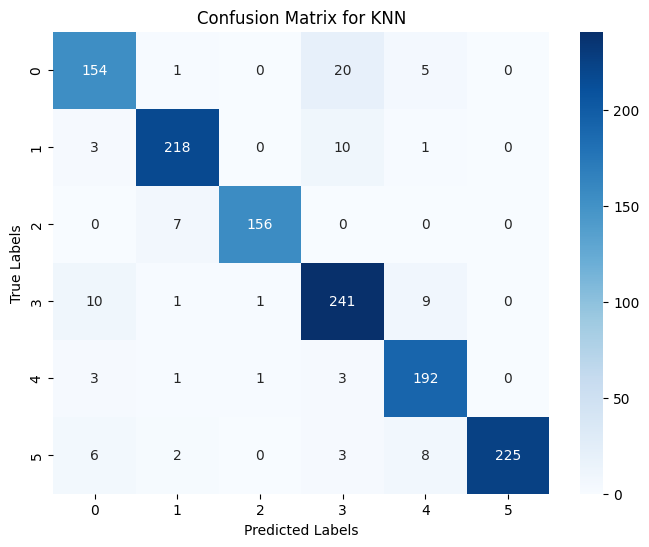

=== SVM ===
Accuracy: 0.9328649492583919
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       180
           1       0.93      0.95      0.94       232
           2       0.99      0.99      0.99       163
           3       0.90      0.89      0.89       262
           4       0.92      0.92      0.92       200
           5       0.99      0.94      0.97       244

    accuracy                           0.93      1281
   macro avg       0.93      0.94      0.93      1281
weighted avg       0.93      0.93      0.93      1281

Precision for SVM: 0.93
Recall for SVM: 0.93
F1-Score for SVM: 0.93


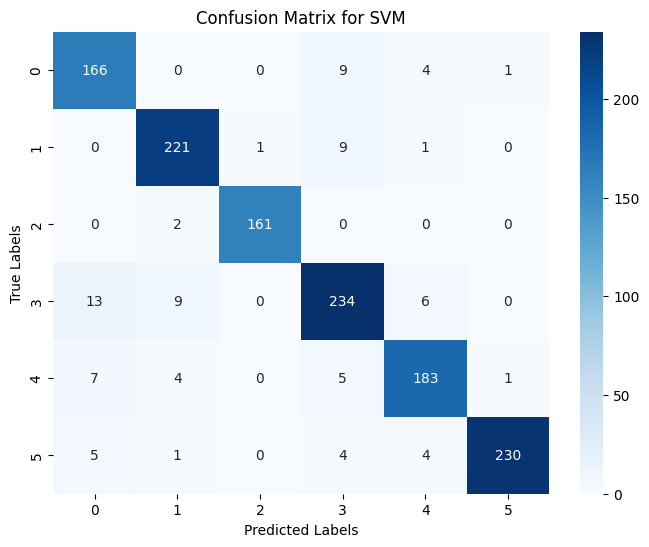

=== Random Forest ===
Accuracy: 0.8173302107728337
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.72      0.77       180
           1       0.81      0.85      0.83       232
           2       0.93      0.87      0.90       163
           3       0.76      0.78      0.77       262
           4       0.83      0.76      0.79       200
           5       0.79      0.91      0.85       244

    accuracy                           0.82      1281
   macro avg       0.83      0.81      0.82      1281
weighted avg       0.82      0.82      0.82      1281

Precision for Random Forest: 0.82
Recall for Random Forest: 0.82
F1-Score for Random Forest: 0.82


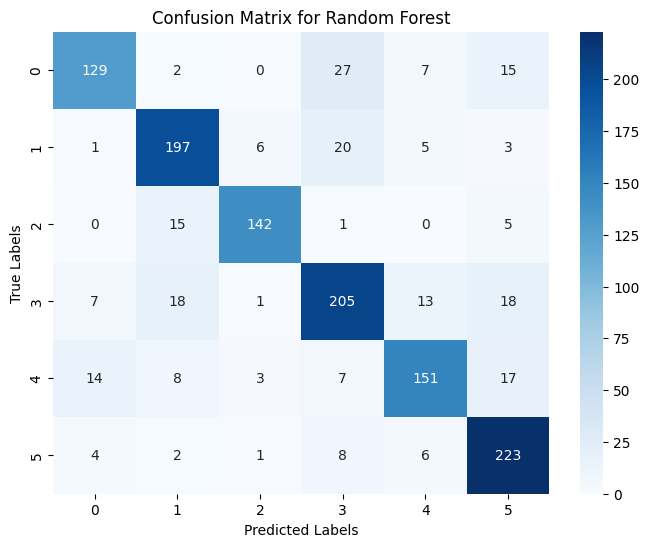


=== Summary of Results ===
KNN -> Precision: 0.9281, Recall: 0.9258, F1-Score: 0.9263
SVM -> Precision: 0.9340, Recall: 0.9329, F1-Score: 0.9332
Random Forest -> Precision: 0.8196, Recall: 0.8173, F1-Score: 0.8166


In [ ]:
# draw and save function
def plot_confusion_matrix(y_test, y_pred, model_name, save_path="."):

    # calculate confusion_matrix
    cm = confusion_matrix(y_test, y_pred)

    # create archive folder if it does not exist
    os.makedirs(save_path, exist_ok=True)

    # draw confusion_matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # save emage to file
    save_file_path = os.path.join(save_path, f"{model_name}_Confusion_Matrix.png")
    plt.savefig(save_file_path, dpi=300)
    plt.show()

    # Close chart after saving
    plt.close()

# print evaluation results function
def evaluate_model(model_name, y_test, y_pred):
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # extract the indexes from classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    # print
    print(f"Precision for {model_name}: {precision:.2f}")
    print(f"Recall for {model_name}: {recall:.2f}")
    print(f"F1-Score for {model_name}: {f1_score:.2f}")
    return precision, recall, f1_score

# draw and evaluate confusion matrix for models
results = {}

# K-nearest neighbors
y_pred_knn = knn.predict(X_test)
results["KNN"] = evaluate_model("KNN", y_test, y_pred_knn)
plot_confusion_matrix(y_test, y_pred_knn, "KNN", save_path="confusion_matrices")

# #Support Vector Machine
y_pred_svm = svm.predict(X_test)
results["SVM"] = evaluate_model("SVM", y_test, y_pred_svm)
plot_confusion_matrix(y_test, y_pred_svm, "SVM", save_path="confusion_matrices")

# Random Forest
y_pred_rf = rf.predict(X_test)
results["Random Forest"] = evaluate_model("Random Forest", y_test, y_pred_rf)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest", save_path="confusion_matrices")

# print results
print("\n=== Summary of Results ===")
for model, metrics in results.items():
    print(f"{model} -> Precision: {metrics[0]:.4f}, Recall: {metrics[1]:.4f}, F1-Score: {metrics[2]:.4f}")

In [ ]:
# Accuracy to evaluate
results = {
    "Model": ["KNN", "SVM", "Random Forest"],
    "Accuracy": [
        round(accuracy_score(y_test, knn.predict(X_test)),4),
        round(accuracy_score(y_test, svm.predict(X_test)),4),
        round(accuracy_score(y_test, rf.predict(X_test)),4),
    ]
}

df_results = pd.DataFrame(results)
print(df_results)

           Model  Accuracy
0            KNN    0.9258
1            SVM    0.9329
2  Random Forest    0.8173


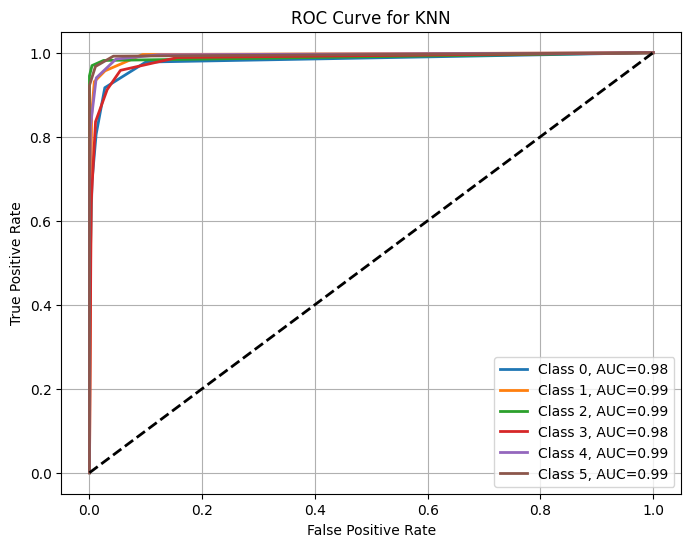

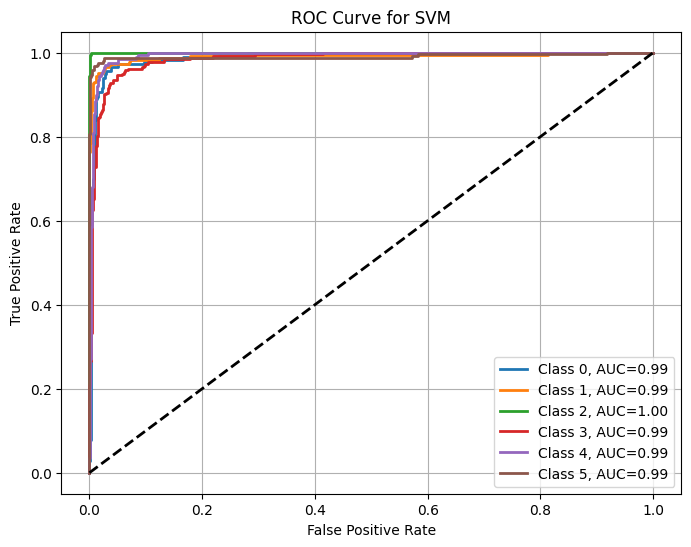

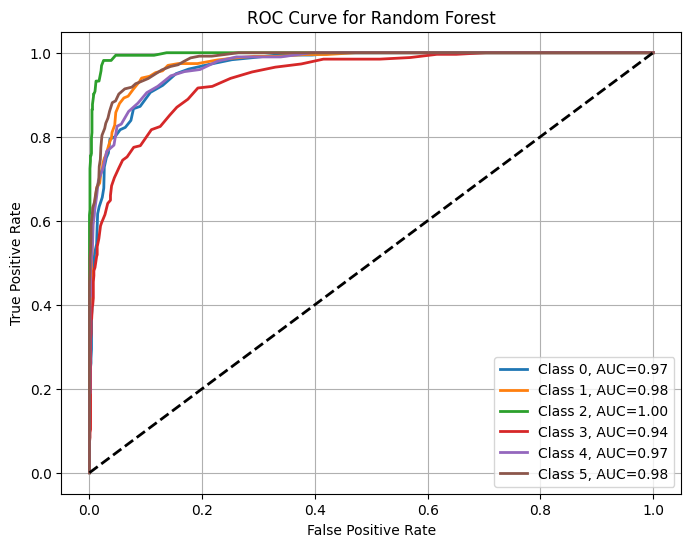

In [ ]:
# Convert labels to binary if it is a multi-class
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Create models
models = [("KNN", knn), ("SVM", svm), ("Random Forest", rf)]

# draw and save ROC plot for models
for model_name, model in models:
    plt.figure(figsize=(8, 6))

    # probability prediction
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)

    # calculate for ROC and AUC for models
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i}, AUC={roc_auc:.2f}")

    # draw random diagonal lines
    plt.plot([0, 1], [0, 1], "k--", lw=2)

    # chart format
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.grid()

    # save chart to image file
    plt.savefig(f"{model_name}_ROC.png", dpi=300)
    plt.show()
    plt.close()